Cloning into 'food101'...
remote: Enumerating objects: 6220, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 6220 (delta 1), reused 16 (delta 1), pack-reused 6200 (from 4)
Receiving objects: 100% (6220/6220), 169.23 MiB | 14.33 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (6256/6256), done.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


70/70 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.3800 - loss: 2.1650 - val_accuracy: 0.6047 - val_loss: 4.4104 - learning_rate: 0.0010
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 89s 846ms/step - accuracy: 0.7359 - loss: 0.9136 - val_accuracy: 0.7590 - val_loss: 1.5280 - learning_rate: 0.0010
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 66s 844ms/step - accuracy: 0.8120 - loss: 0.6643 - val_accuracy: 0.7477 - val_loss: 1.5862 - learning_rate: 0.0010
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 885ms/step - accuracy: 0.8366 - loss: 0.5831 - val_accuracy: 0.7646 - val_loss: 1.0834 - learning_rate: 0.0010
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 82s 854ms/step - accuracy: 0.8501 - loss: 0.5337 - val_accuracy: 0.7995 - val_loss: 1.0895 - learning_rate: 0.0010
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 84s 884ms/step - accuracy: 0.8671 - loss: 0.4385 - val_accuracy: 0.8187 - val_loss: 0.8423 - learning_rate: 0.0010
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 68s 872ms/step - accuracy: 0.8804 - loss: 0.4140 - val_ac

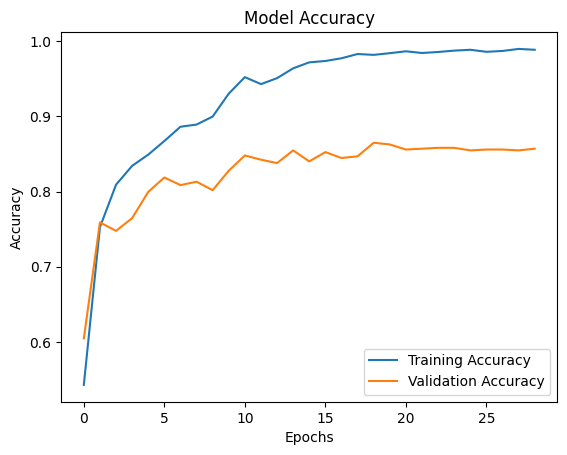

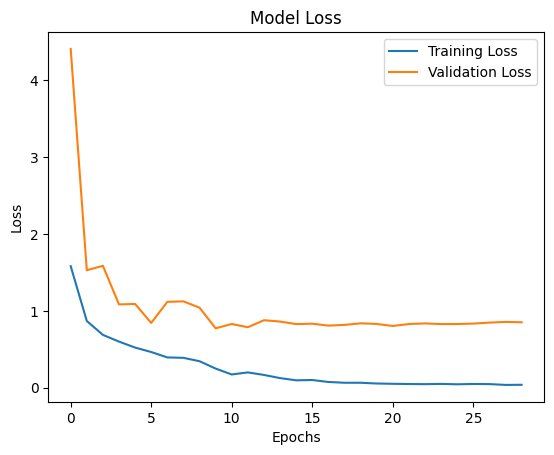

In [1]:
!git clone https://github.com/Bhavnoor-Coders-1010/food101.git
import cv2
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder

train_df = pd.read_csv('/content/food101/DataFOOD101/train.csv')
y_train = train_df['label']
x_train = train_df['imagePath']
x_train = np.array([cv2.resize(cv2.imread('/content/food101/DataFOOD101/Train/' + str(img)), (224, 224)) for img in x_train])

test_df = pd.read_csv('/content/food101/DataFOOD101/test.csv')
y_test = test_df['label']
x_test = test_df['imagePath']
x_test = np.array([cv2.resize(cv2.imread('/content/food101/DataFOOD101/Test/' + str(img)), (224, 224)) for img in x_test])

n_validation = 888
x_validation = x_train[-n_validation:]
y_validation = y_train[-n_validation:]
x_train = x_train[:-n_validation]
y_train = y_train[:-n_validation]

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(x_train)

# OneHotEncode labels
oh = OneHotEncoder(sparse_output=False)
y_train_encoded = oh.fit_transform(y_train.values.reshape(-1, 1))
y_validation_encoded = oh.transform(y_validation.values.reshape(-1, 1))
y_test_encoded = oh.transform(y_test.values.reshape(-1, 1))

# Load ResNet50 as the base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True  # Fine-tuning: Unfreeze layers

for layer in base_model.layers[:-10]:  # Fine-tune only the last 10 layers
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation="relu"),
    layers.Dropout(0.3),  # Regularization
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(256, activation="relu"),
    layers.Dense(20, activation="softmax"),  # Number of classes
])

model.compile(
    optimizer=Adam(learning_rate=0.001),  # Fine-tuning learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add callbacks
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model
batch_size = 64
n_epochs = 50
history = model.fit(
    datagen.flow(x_train, y_train_encoded, batch_size=batch_size),
    epochs=n_epochs,
    validation_data=(x_validation, y_validation_encoded),
    callbacks=[lr_scheduler, early_stopping]
)

# Evaluate the model
results = model.evaluate(x_test, y_test_encoded)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1] * 100, "%")

# Save the trained model
model.save('Food101_final.keras')

# Visualization of accuracy and loss
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Inference function for predictions
def Food101(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    model = keras.models.load_model('Food101_final.keras')
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)
    return predicted_class[0]

# Food list mapping
Food_list = {
    0: "burger",
    1: "butter_naan",
    2: "chai",
    3: "chapati",
    4: "chole_bhature",
    5: "dal_makhani",
    6: "dhokla",
    7: "fried_rice",
    8: "idli",
    9: "jalebi",
    10: "kathi_roll",
    11: "kadhai_paneer",
    12: "kulfi",
    13: "masala_dosa",
    14: "momos",
    15: "paani_puri",
    16: "pakode",
    17: "pav_bhaji",
    18: "pizza",
    19: "samosa"
}


Saving test_sample_1.jpg to test_sample_1.jpg


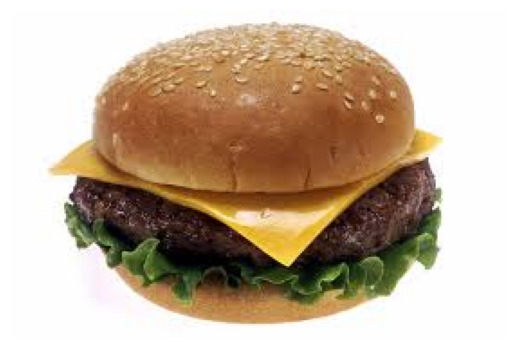

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
You prolly showed us burger


In [6]:
from google.colab import files
import matplotlib.pyplot as plt
import cv2

# Step 1: Upload the file
uploaded = files.upload()

# Step 2: Access the uploaded file
file_name = list(uploaded.keys())[0]
image = cv2.imread(file_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB for proper colors
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.show()
x = Food101(file_name)
print("You prolly showed us " + Food_list[x])

Saving test_sample_2.jpg to test_sample_2 (1).jpg


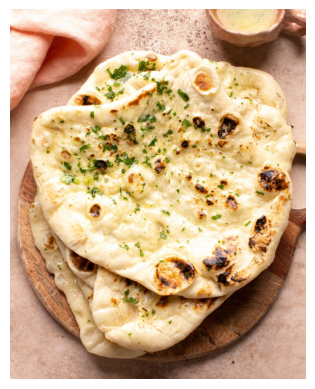

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
You prolly showed us butter_naan


In [7]:
from google.colab import files
import matplotlib.pyplot as plt
import cv2

# Step 1: Upload the file
uploaded = files.upload()

# Step 2: Access the uploaded file
file_name = list(uploaded.keys())[0]
image = cv2.imread(file_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB for proper colors
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.show()
x = Food101(file_name)
print("You prolly showed us " + Food_list[x])